In [6]:
!pip install -qU diffusers accelerate transformers huggingface_hub

In [7]:
from huggingface_hub import notebook_login
notebook_login()

# Understanding pipelines, models and schedulers

With the HuggingFace Diffusers library, users are able to build diffusion systems tailored to their specific use-case.

While the `DiffusionPipeline` bundles the models and schedulers together for convenience, we can also unbundle the pipeline and use the models and schedulers to create new diffusion systems.

## Deconstruct a basic pipeline

A pipeline is a quick and easy way to run a model for inference.

In [8]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained(
    'google/ddpm-cat-256',
    #use_safetensors=True,
).to('cuda')

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cat-256/snapshots/82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cat-256/snapshots/82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/25 [00:00<?, ?it/s]

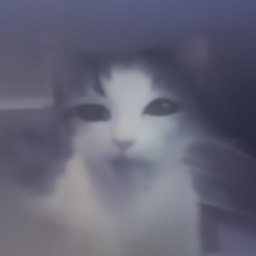

In [ ]:
image = ddpm(num_inference_steps=25).images[0]
image

In the example above, the pipeline contains a `UNet2DModel` model and a `DDPMScheduler`.
1. The pipeline denoises an image by taking random noise the size of the desired output and passing it through the model several times.
2. At each timestep, the model predict the *noise residual* and the scheduler uses it to predict a less noisy image.
3. The pipeline repeats this process until it reaches the end of the speicified number of inference steps.

To recreate the pipeline with the model and scheduler separately, we will write our own denoising process.

1. Load the model and scheduler:

In [9]:
from diffusers import DDPMScheduler, UNet2DModel

ckpt_name = 'google/ddpm-cat-256'
scheduler = DDPMScheduler.from_pretrained(ckpt_name)
model = UNet2DModel.from_pretrained(
    ckpt_name,
    use_safetensors=True,
).to('cuda')

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

2. Set the number of timesteps to run the denoising process:

In [10]:
timesteps = 50
scheduler.set_timesteps(timesteps)

3. Setting the scheduler timesteps creates a tensor with evenly spaced elements in it. Each element corresponds to a timestep at which the model denoises an image. When we create the denoising loop later, we will iterate over this tensor to denoise an image:

In [11]:
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

4. Create some random noise with the same shape as the desired output:

In [12]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device='cuda')
noise.shape

torch.Size([1, 3, 256, 256])

5. Wrte a loop to iterate over the timesteps. At each timestep, the model does a `UNet2DModel.forward()` pass and returns the noisy residual. The scheduler's `step()` method takes the noisy residual, timestep, and input and it predicts the image at the previous timestep. This output becomes the next input to the model in the denoising loop, and it will repeat until it reaches the end of the `timesteps` array.

In [13]:
img_input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(img_input, t).sample

    previous_noisy_sample = scheduler.step(noisy_residual, t, img_input).prev_sample
    img_input = previous_noisy_sample

This is the entire denoising process, and we can use the same pattern to write any diffusion system.

6. The last step is to convert the denoised output into an image.

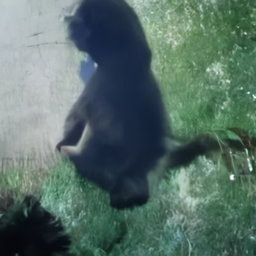

In [14]:
from PIL import Image
import numpy as np

image = (img_input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

## Deconstruct the Stable Diffusion pipeline

**Stable Diffusion** is a text-to-image *latent diffusion* model, because it works with a lower-dimensional representation of the image instead of the actual pixel space, which makes it more memory efficient.

The encoder compresses the image into a smaller representation, and a decoder to convert the compressed representation back into an image.

For text-to-image models, we will need a tokenizer and an encoder to generate text embeddings. The Stable Diffusion model has three separate pretrained models.

In [15]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

ckpt_name = 'CompVis/stable-diffusion-v1-4'
vae = AutoencoderKL.from_pretrained(
    ckpt_name,
    subfolder='vae',
    use_safetensors=True,
)
tokenizer = CLIPTokenizer.from_pretrained(
    ckpt_name,
    subfolder='tokenizer',
)
text_encoder = CLIPTextModel.from_pretrained(
    ckpt_name,
    subfolder='text_encoder',
    use_safetensors=True,
)
unet = UNet2DConditionModel.from_pretrained(
    ckpt_name,
    subfolder='unet',
    use_safetensors=True,
)

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Instead of the default `PNDMScheduler`, exchange it for the `UniPCMultistepScheduler` to see how easy it is to plug a different scheduler in:

In [17]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained(
    ckpt_name,
    subfolder='scheduler',
)

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

To speed up inference, move the models to a GPU: (scheduler does not have trainable weights so we do not need to move it to GPU)

In [18]:
torch_device = 'cuda'
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

### Create text embeddings

The next step is to tokenize the text to generate embeddings. The text is used to condition the UNet model and steer the diffusion process towards the input prompt.

The `guidance_scale` parameter determines how much weight should be given to the prompt when generating an image.

In [37]:
prompt = ['a photograph of an astronaut riding a horse in space.']
height = 512 # default height of SD
width = 512 # default width of SD
num_inference_steps = 25 # number of denoising steps
guidance_scale = 7.5 # scale for `classifier-free guidance` (cfg)
generator = torch.Generator(device=torch_device).manual_seed(111) # seed generator to create the initial latent noise
batch_size = len(prompt)

Tokenize the text and generate the embeddings from the prompt:

In [20]:
text_input = tokenizer(
    prompt,
    padding='max_length',
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors='pt',
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

We will also need to generate the *unconditional text embeddings* which are the embeddings for the padding token. These need to have the same shape (`batch_size` and `seq_length`) as the conditional `text_embeddings`:

In [21]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [22]:
text_embeddings

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.4595,  0.5617,  1.6663,  ..., -1.9515, -1.2307,  0.0104],
         ...,
         [-2.7634,  0.1326,  0.0625,  ...,  0.3589, -0.0743,  0.5267],
         [-2.7727,  0.1375,  0.0565,  ...,  0.3577, -0.0754,  0.5300],
         [-2.7252,  0.1334,  0.0593,  ...,  0.4130, -0.0585,  0.5071]]],
       device='cuda:0')

In [23]:
uncond_embeddings

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

Now let's concatenate the conditional and unconditional embeddings into a batch to avoid doing two forward passes:

In [24]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
text_embeddings

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],

        [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.4595,  0.5617,  1.6663,  ..., -1.9515, -1.2307,  0.0104],
         ...,
         [-2.7634,  0.1326,  0.0625,  ...,  0.3589, -0.0743,  0.5267],
         [-2.7727,  0.1375,  0.0565,  ...,  0.3577, -0.0754,  0.5300],
         [-2.7252,  0.1334,  0.0593,  ...,  0.4130, -0.0585,  0.5071]]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [25]:
text_embeddings.shape

torch.Size([2, 77, 768])

### Create random noise

Next, generate some initial random noise as a starting point for the diffusion process. This is the latent representation of the image, and it will be gradually denoised. At this point, the `latent` iamge is smaller than the final image size and the model will transform it into the final 512x512 image dimension later.

In [38]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)
latents.shape

torch.Size([1, 4, 64, 64])

The height and width are divided by 8 because the `vae` model has 3 downsampling layers:

In [39]:
2 ** (len(vae.config.block_out_channels) - 1)

8

In [41]:
vae.config.block_out_channels

[128, 256, 512, 512]

### Denoise the image

Start by scaling the input with the initial noise distribution, *sigma*, the noise scale value, which is required for improved schedulers like `UniPCMultistepScheduler`

In [45]:
latents = latents * scheduler.init_noise_sigma

The last step is to create the denoising loop that will progressively transform the pure noise in `latents` to an image described by our prompt.

The denoising loop needs to do three things:
1. Set the scheduler's timesteps to use during denoising.
2. Iterate over the timesteps.
3. At each timestep, call the UNet model to predict the noise residual and pass it to the scheduler to compute the previous noisy sample.

In [46]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # Expand the latents if we are doing classifier-free guidance to avoid doing two forward passes
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # Predict the noise residual
    with torch.no_grad():
        noise_pred = unet(
            latent_model_input,
            t,
            encoder_hidden_states=text_embeddings,
        ).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(
        noise_pred,
        t,
        latents,
    ).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

In [47]:
latents.shape

torch.Size([1, 4, 64, 64])

### Decode the image

The final step is to use the `vae` to decode the latent representation into an image and get the decoded output with `sample`

In [48]:
# scale and decode the image latents with vae
latents = 1 / 0.18125 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

image.shape

torch.Size([1, 3, 512, 512])

Lastly, convert the image to a `PIL.Image`:

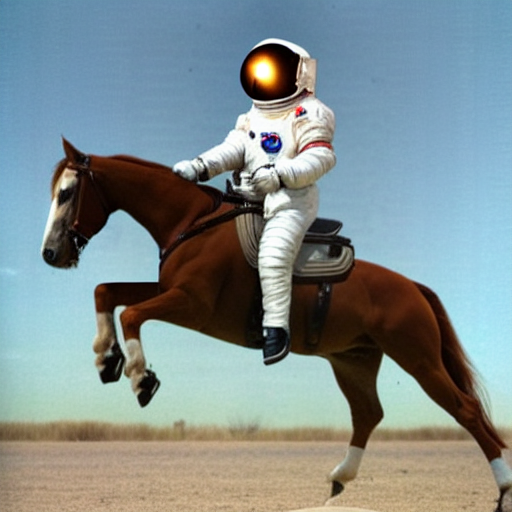

In [50]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image